In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import shutil
import glob
import time

# Load data

In [2]:
# Create plots directory if it doesn't exist
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Load Data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# Device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")


Using mps device


# Build Neural Network

In [4]:
# Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Training Loop

In [5]:
# Training loop
def train_and_evaluate(name, config, train_data, test_data, device):
    print(f"\n--- Training {name} ---")
    hidden_size = 512
    batch_size = 64
    epochs = 10
    
    lr = config['lr']
    optimizer_type = config['optimizer']
    momentum = config.get('momentum', 0.0)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    model = NeuralNetwork(hidden_size=hidden_size).to(device)
    loss_fn = nn.CrossEntropyLoss()

    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    history = []
    
    start_time = time.time()
    for t in range(epochs):
        model.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= size
        history.append(correct)
        print(f"Epoch {t+1}/{epochs} - Accuracy: {correct:.4f}")
        
    print(f"Finished {name} in {time.time()-start_time:.2f}s")
    return history

# Compare optimizers configuration

In [6]:
# Configurations
configs = {
    'SGD': {'optimizer': 'SGD', 'lr': 0.01, 'momentum': 0.0},
    'SGD + Momentum': {'optimizer': 'SGD', 'lr': 0.01, 'momentum': 0.9},
    'RMSprop': {'optimizer': 'RMSprop', 'lr': 0.001},
    'Adam': {'optimizer': 'Adam', 'lr': 0.001}
}


In [7]:
results = {}

# Run Experiments
for name, config in configs.items():
    results[name] = train_and_evaluate(name, config, training_data, test_data, device)



--- Training SGD ---
Epoch 1/10 - Accuracy: 0.7156
Epoch 2/10 - Accuracy: 0.7773
Epoch 3/10 - Accuracy: 0.7952
Epoch 4/10 - Accuracy: 0.8156
Epoch 5/10 - Accuracy: 0.8244
Epoch 6/10 - Accuracy: 0.8245
Epoch 7/10 - Accuracy: 0.8316
Epoch 8/10 - Accuracy: 0.8296
Epoch 9/10 - Accuracy: 0.8394
Epoch 10/10 - Accuracy: 0.8424
Finished SGD in 41.11s

--- Training SGD + Momentum ---
Epoch 1/10 - Accuracy: 0.8222
Epoch 2/10 - Accuracy: 0.8431
Epoch 3/10 - Accuracy: 0.8495
Epoch 4/10 - Accuracy: 0.8687
Epoch 5/10 - Accuracy: 0.8666
Epoch 6/10 - Accuracy: 0.8722
Epoch 7/10 - Accuracy: 0.8722
Epoch 8/10 - Accuracy: 0.8785
Epoch 9/10 - Accuracy: 0.8837
Epoch 10/10 - Accuracy: 0.8846
Finished SGD + Momentum in 48.11s

--- Training RMSprop ---
Epoch 1/10 - Accuracy: 0.8185
Epoch 2/10 - Accuracy: 0.8538
Epoch 3/10 - Accuracy: 0.8288
Epoch 4/10 - Accuracy: 0.8402
Epoch 5/10 - Accuracy: 0.8600
Epoch 6/10 - Accuracy: 0.8759
Epoch 7/10 - Accuracy: 0.8700
Epoch 8/10 - Accuracy: 0.8829
Epoch 9/10 - Accurac


Saved comparison plot to plots/optimizer_comparison.png


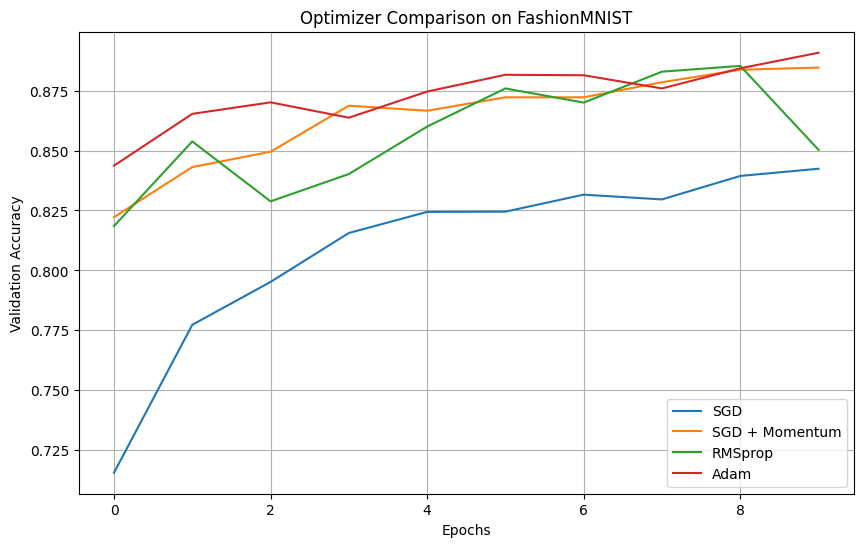

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
for name, acc in results.items():
    plt.plot(acc, label=name)

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Optimizer Comparison on FashionMNIST')
plt.legend()
plt.grid(True)

output_path = os.path.join(plots_dir, 'optimizer_comparison.png')
plt.savefig(output_path)
print(f"\nSaved comparison plot to {output_path}")